In [1]:
import numpy as np
import mne
from pathlib import Path
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import pandas as pd
from mne.filter import filter_data 
%matplotlib inline

<h1>
    How to analyse and use data received from BCI.
</h1>
<p>
    We will analyze this question on the example of our study: we want to find empirical evidence of the influence of meditation on developers` performance.
    Most of our algorithm works with mne library, so here is the <a href="https://martinos.org/mne/stable/auto_tutorials/intro/plot_introduction.html#sphx-glr-auto-tutorials-intro-plot-introduction-py\">Overview of MEG/EEG analysis with MNE-Python</a>
</p>
<p>
    Before working with information we should load files.
</p>
<p>
    When analyzing the information obtained from the BSI, firstly, we should  understand what part of the available information is necessary for us to work.
    For example, in our study we have only 8 channels, so we should cut all other data. Also we need only frequencies lower than 50 Hz, so we filter them. When you decided on which data you need and which you don't need, you should cut it off as well.
</p>
<p>
    Secondly, you need to fit your data into functions you want to work with. For example, in our study we work with mne library, so we: <ul>
        <li>Converted microvolts into volts, because mne works only with volts.</li>
        <li>Filtered our data on range [2:50], because ICA works with this range</li>
        <li>...</li>
    </ul>
    You also should make corrections with correspondence to your libraries and functions.
</p>
<p>
    After preprocessing data you should use some functions, which will draw your processed data, if it is needed.
    In our study it is not necessary, but it gives better understanding of data, with which we would work.
</p>
<p>
    After visualising data we need to execute some algorithm, which will give some valuable information from preprocessed data.
    In our case, we make vectors from epochs, constructed from data, and compute spatial distance between vectors. Based on these distance we check similarity of our data sequences.
</p>

<p>
To prepare acquired information before using we should:
<ol>
<li>load data</li>
<li>preprocess data</li>
</ol>
To get results after data processing we need to:
<ol>
<li>visualize processed data</li>
<li>interpret processed and visualized data</li>
</ol>
</p>



<h3>Preprocessing</h3>

<ul>
<li>Firstly, we need to convert units, because mne library works only with volts, while in raw data we have data in volts.</li>
<li>After that we should cut off all unneeded data. Since we work only with 8 channels, we don't need other columns (SampleIndex, TimeStamp and Accel Data). Example of data we have after cutting off:</br>0.00, -476.03, -1125.54, -1217.12, -1151.03, -1294.34, -1167.79, -994.50</li>
<li>When we have only data from 8 channels, we should filter it in frequency range [2:50] Hz, because we are not interested in other frequencies.</li>
<li>When we already cut and filtered our data, we should chop it into epochs (lenght of epochs in our case is 10 seconds). It will help to work with data in more complex and flexible ways.</li>
</ul>

<h3>Converting units</h3>
<p>Transforms the microvolts from source BCI file to volts, since mne library works with volts rather than with microvolts.</p>

In [2]:
def microvolts_to_volts(value):
    """
    Since openBCI writes data into micro volts and mne works with volts we
    will need to convert the data later.
    :param value: single micro volts value
    :return: same value in volts
    """
    return float(value) / 1000

<h3>Filtering and cutting data</h3> 
<p>In this code block we filter the raw input from txt file. <ol><li>Load data from txt source using converter to get valuable data, etc to cut off unneeded data by keeping track only info from 8 channels attached to their names</li><li>We filter out data with frequency in range [2,50] Hz for being able to use ICA. The function filter works applying FFT on finite number of points and combines the data to return. <br/><a href="https://martinos.org/mne/dev/auto_tutorials/discussions/plot_background_filtering.html#sphx-glr-auto-tutorials-discussions-plot-background-filtering-py"><image src = "https://martinos.org/mne/dev/_images/sphx_glr_plot_background_filtering_016.png" /></a><br/> We can eliminate orange oscilations by "cutting off" high frequencies

In [3]:
def load_openbci_file(filename, ch_names=None, skiprows=0, max_rows=0):
    """
    Load data from OpenBCI file into mne RawArray for later use
    
    REQUIRES: numpy.version >= 1.16
    :param filename: filename for reading in form of relative path from working directory
    :param ch_names: dictionary having all or some channels like this:
            {"fp1":1, "fp2":2, "c3":3, "c4":4, "o1":5, "o2":6, "p3":7, "p4":8}
            Key specifies position on head using 10-20 standard and
            Value referring to channel number on Cyton BCI board
    :return: RawArray class of mne.io library
    """
    if ch_names is None:
        ch_names = {"fp1":1, "fp2":2, "c3":3, "c4":4, "o1":5, "o2":6, "p3":7, "p4":8}

    # Converter of BCI file to valuable data
    converter = {i: (microvolts_to_volts if i < 12 else lambda x: str(x).split(".")[1][:-1])
                 for i in range(0, 13)}

    info = mne.create_info(
        ch_names=list(ch_names.keys()),
        ch_types=['eeg' for i in range(0, len(ch_names))],
        sfreq=250,
        montage='standard_1020'
    )
    data = np.loadtxt(filename, comments="%", delimiter=",",
                      converters=converter, skiprows=skiprows, max_rows=max_rows).T

    data = data[list(ch_names.values())]

    data = filter_data(data, 250, l_freq=2, h_freq=50)

    return mne.io.RawArray(data, info)

<h3>Splitting data into peaces</h3>
<p>We divide the data flow that come from the above function using the create_epochs method into 10 second durated time intervals. Moreover, we cut first and last 40s in each sample, since the data on this intervals noised and uncredible.</p>

In [4]:
def create_epochs(raw_data, duration=1):
    """
    Chops the RawArray onto Epochs given the time duration of every epoch
    :param raw_data: mne.io.RawArray instance
    :param duration: seconds for copping
    :return: mne Epochs class
    """
    events = mne.make_fixed_length_events(raw_data, duration=duration)
    epochs = mne.Epochs(raw_data, events, preload=True)
    return epochs

<p>
We load raw data in form of sequence of signals in certain format:
<ul>
<li>First column is SampleIndex</li>
<li>Last column is Timestamp </li>
<li>Other columns are: EEG data in microvolts(8 channels) followed by Accel Data (in G) interleaved with Aux Data</li>
</ul>
</p>

In [5]:
def get_sample_data(path, regx):
    files = get_files(path, regx)
    ch_names = {"fp2":1, "fp1":2, "f4":3, "f3":4, "c4":5, "c3":6, "o2":7, "o1":8}
    raw_data = []
    for file in files:
        raw_data.append(load_openbci_file(file, ch_names=ch_names, skiprows=10000, max_rows=50000))
    real_data_series = [create_epochs(raw) for raw in raw_data]
    return real_data_series[-1]

<h3>Loading files</h3>
<p>We load all files needed (we determine files by pattern and their directory)</p>

<h3>Merging epochs</h3>
<p>We merge epochs into sequences: one sequence for each channel.</p> 

In [6]:
def get_files(dir='.', pattern='*.txt'):
    """
    Loading files from given directory with specified pattern.
    :param dir: Lookup directory
    :param pattern: Pattern for files. Default *.txt for loading raw BCI files
    :return: array of file paths
    """
    # Specifying files directory, select all the files from there which is txt
    datadir = Path(dir).glob(pattern)
    # Transferring generator into array of file paths
    return [x for x in datadir]


In [7]:
def get_sample_data(path, regx):
    files = get_files(path, regx)
    ch_names = {"fp2":1, "fp1":2, "f4":3, "f3":4, "c4":5, "c3":6, "o2":7, "o1":8}
    raw_data = []
    for file in files:
        raw_data.append(load_openbci_file(file, ch_names=ch_names, skiprows=10000, max_rows=50000))
    real_data_series = [create_epochs(raw) for raw in raw_data]
    return real_data_series[-1]
    

Defining Constants 

In [8]:
 # TAKE ONE RANDOM RECORDING FOR PLOTTING
n_channels = 8
SAMPLE_FREQ = 250

Next applying ICA and print the filters.

Note: Filter ID may not be the same as channel ID.


In [9]:
def transform_ICA(sample_data):
    ica = ICA()
    ica.fit(sample_data)
    ica.plot_components()
    return ica.apply(sample_data) # Transform recording into ICA space

<h3>Building table with useful data</h3>
<p>We divide our data into five groups by their frequencies:
<ul><li>Delta: 0-4</li><li>Theta: 4-8</li><li>Alpha: 8-12</li><li>Beta: 12-30</li><li>Gamma: 30-45</li></ul></p>
<p>After that we evaluate mean for each of these sequences and draw table based in this data.</p>

Defining Constants 

In [10]:
 # TAKE ONE RANDOM RECORDING FOR PLOTTING
n_channels = 8
SAMPLE_FREQ = 250

Next applying ICA and print the filters.

Note: Filter ID may not be the same as channel ID.


In [11]:
def transform_ICA(sample_data):
    ica = ICA()
    ica.fit(sample_data)
    ica.plot_components()
    return ica.apply(sample_data) # Transform recording into ICA space

# Convert data into vector
Try different approaches. Next is an attempt to see overall recording waves.
Free to change everything next.

<h3>Merging epochs</h3>
<p>We merge epochs into sequences: one sequence for each channel.</p> 

In [12]:
def remove_epochs(data_epochs):
    dat = data_epochs.get_data()
    data = np.zeros( (dat.shape[0] * dat.shape[2], 8) )
    n_epoch = len(dat)
    n_in_epoch = dat.shape[2]
    for i in range(n_epoch):
        data[i*n_in_epoch:i*n_in_epoch + n_in_epoch] = dat[i].T
    
    return data

<h3>Building table with useful data</h3>
<p>We divide our data into five groups by their frequencies:
<ul><li>Delta: 0-4</li><li>Theta: 4-8</li><li>Alpha: 8-12</li><li>Beta: 12-30</li><li>Gamma: 30-45</li></ul></p>
<p>After that we evaluate mean for each of these sequences and draw table based in this data.</p>

In [13]:
def build_table(data):
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/SAMPLE_FREQ)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)

    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")
    return df

<h3>Interpreting data</h3>

<p>
Vectorization/normalization: //TODO
</p>

<p>
Computing spatial distance of vectors: //TODO
</p>

<p>
Checking for different pairs of input (med|cod; med|med; cod|cod): //TODO
</p>

<h3>Vectorizing</h3>
<p>We compute mean of sequences for each epoch and wave type with the same method as above.</p>
<p>After that we compute the ratio between Alpha and Gamma values for every epoch and place all such ratios in one vector</p>

In [14]:
def vectorize(sample_data):
    vector = []
    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}
    
    ch_names = {"fp2":0, "fp1":1, "f4":2, "f3":3, "c4":4, "c3":5, "o2":6, "o1":7}
    
    sample_data = sample_data.get_data()
    
    analysis_data = np.zeros( (sample_data.shape[0],
                               sample_data.shape[1]//2, sample_data.shape[2]) )
    i = 0
    for sample_epoch in sample_data:
        analysis_data[i][0] = (sample_epoch[1] - sample_epoch[0]) / \
                              (sample_epoch[1] + sample_epoch[0])
        analysis_data[i][1] = (sample_epoch[3] - sample_epoch[2]) / (sample_epoch[3] + sample_epoch[2])
        analysis_data[i][2] = (sample_epoch[5] - sample_epoch[4]) / (sample_epoch[5] + sample_epoch[4])
        analysis_data[i][3] = (sample_epoch[7] - sample_epoch[6]) / (sample_epoch[7] + sample_epoch[6])
        i+=1
        
        
    for epoch in analysis_data:
    
     # Get real amplitudes of FFT (only in postive frequencies)
        fft_vals = np.absolute(np.fft.rfft(epoch.T))

        # Get frequencies for amplitudes in Hz
        fft_freq = np.fft.rfftfreq(len(epoch.T), 1.0/SAMPLE_FREQ)
        eeg_band_fft = dict()
    
        for band in eeg_bands:
            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                               (fft_freq <= eeg_bands[band][1]))[0]
            eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    
        vector.append(eeg_band_fft['Alpha'] / eeg_band_fft['Beta'])
    
    return np.array(vector)

<h3>Visualising</h3>

<p>
We fit processed data into ICA space, so we will be able to work with ICA.
</p>

<p>
For example, ICA filters allows us to see how engaged subject was into the task solving process.
</p>

<p>
We also can construct some table from epochs information to better understand some things.
</p>

<p>
<a href="https://lh5.googleusercontent.com/e0vMWn7hUC4lXMu6GmziN_tDKrS0Qz-im8cjTKt8R9gSW4v_8c63UBy7EksDMyXyP1tzFvuXrcSlsc0tPXdNbgcZIPpLS3mP0B01lypreeaLUxgBTAyVNWrirEX8L7sRdZbhsuuZ0gU">ICA example image 1</a>, 
<a href="https://lh6.googleusercontent.com/yih8YkpazRtIKiT6GeSwwUkUJCImRbPCiUrT61Y_wyv3CqpIr_aPEyTnzqrq1bnuBRJguBPD6_n-9aAiwKhtPOWpxrRNScJ-5Ii3yXvDbF41i6lYzSsamQ3QWFFJo3jki3apzoQfXGM">ICA example image 2</a>, 
<a href="https://lh4.googleusercontent.com/GFFX-YBGp3hDraozw615GZ2yCaoXza3sdkVDPUiGOzF2CE32vWAUMCatNp4O94-6mlp2x-B-u4MzO0bx1qunE3GAHqqfx4j4sj76z_nZezaPStNiIr4fZhRIjjfXvOq01dJmBZelOjY">ICA example image 3</a>, 
<a href="https://lh4.googleusercontent.com/vHLOy6jC3TwrlERf1OWT9g7AIasxWvVU9JYEi6ltTgOyWRDktl5611T6pSsHGXho2DgabOJlB1nWFCgNY-Nb4hMPbtsJh4RT40hins9DW5WttksojbEBsziQGBUiZgCb47V4-XSJTGQ">Example of table</a>.
</p>

Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Creating RawArray with float64 data, n_channels=8, n_times=50000
    Range : 0 ... 49999 =      0.000 ...   199.996 secs
Ready.
200 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 200 events and 176 original time points ...
1 bad epochs dropped
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitt

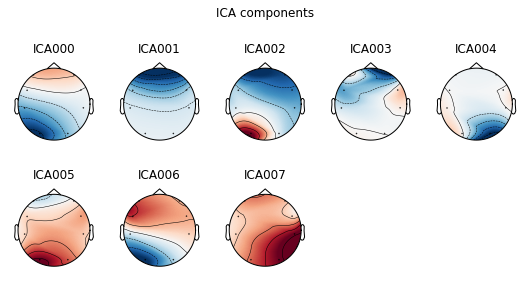

Transforming to ICA space (8 components)
Zeroing out 0 ICA components
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Creating RawArray with float64 data, n_channels=8, n_times=50000
    Range : 0 ... 49999 =      0.000 ...   199.996 secs
Ready.
200 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 200 events and 176 original time points ...
1 bad epochs dropped
Fitting ICA to data using 8 channels (please be patient, this may take a while)
In

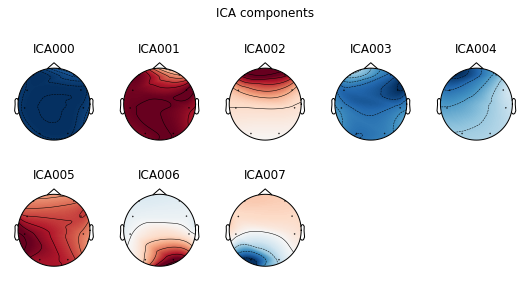

Transforming to ICA space (8 components)
Zeroing out 0 ICA components


In [15]:
sample_data_cod1 = get_sample_data('Dataset', '*Subject3_Session1_Coding*.txt')
sample_data_cod1 = transform_ICA(sample_data_cod1)

sample_data_cod2 = get_sample_data('Dataset', '*Subject1_Session1_Coding*.txt')
sample_data_cod2 = transform_ICA(sample_data_cod2)

<p>
    Example of ICA transformation is given above.
</p>

<h3>Normalization</h3>
<p>We normalize vectors, that we got after vectorization to be able to work with them.<p>

In [16]:
from sklearn.preprocessing import normalize
coding_vec1 = normalize(vectorize(sample_data_cod1)[:,np.newaxis], axis=0).ravel()

coding_vec2 = normalize(vectorize(sample_data_cod2)[:,np.newaxis], axis=0).ravel()

Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Creating RawArray with float64 data, n_channels=8, n_times=50000
    Range : 0 ... 49999 =      0.000 ...   199.996 secs
Ready.
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff 

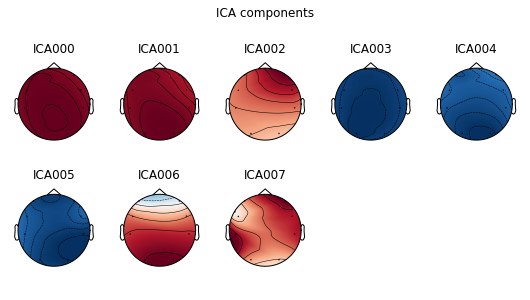

Transforming to ICA space (8 components)
Zeroing out 0 ICA components


In [17]:
sample_data_med = get_sample_data('Dataset', '*Meditation*.txt')
sample_data_med = transform_ICA(sample_data_med)

# table_of_meditation = build_table(remove_epochs(sample_data))

<h3>Normalization</h3>
<p>We normalize vectors, that we got after vectorization to be able to work with them.<p>

In [18]:
from scipy import spatial 
meditation_vec = normalize(vectorize(sample_data_med)[:,np.newaxis], axis=0).ravel()
print(np.mean(meditation_vec))
print(spatial.distance.cosine(coding_vec1, meditation_vec))
print(spatial.distance.cosine(coding_vec1, coding_vec2))

0.03789244994880429
0.9396623760563869
0.7118333704658713


In [19]:
# table_of_meditation.iloc[2, 1] / table_of_meditation.iloc[4, 1]

In [20]:
# table_of_meditation

Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Creating RawArray with float64 data, n_channels=8, n_times=50000
    Range : 0 ... 49999 =      0.000 ...   199.996 secs
Ready.
200 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 200 events and 176 original time points ...
1 bad epochs dropped
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitt

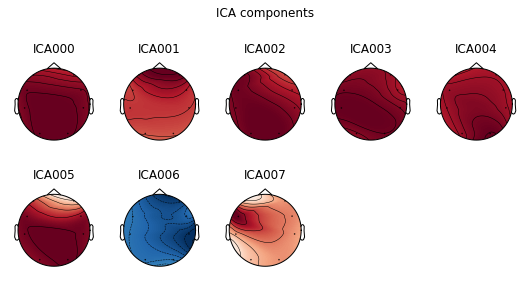

Transforming to ICA space (8 components)
Zeroing out 0 ICA components


In [21]:
sample_data_codmed = get_sample_data('Dataset', '*Subject1_Session2_Coding*.txt')
sample_data_codmed = transform_ICA(sample_data_codmed)
# table_of_codemeditation = build_table(remove_epochs(sample_data))

In [22]:
codemeditation_vec = normalize(vectorize(sample_data_codmed)[:,np.newaxis], axis=0).ravel()

print(spatial.distance.cosine(coding_vec1, codemeditation_vec))
print(spatial.distance.cosine(meditation_vec, codemeditation_vec))

0.944839096178753
0.748451082168266
